# Process Cell Health Labels

The raw data exists as manually edited excel spreadsheets.
Process into a single data frame.

In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
%matplotlib inline

In [3]:
data_dir = os.path.join("data", "raw")
files = os.listdir(data_dir)
files = [x for x in files if '.xlsx' in x]
files

["ES2_375CPW_BenchmarksV1_CellCycle_Avg_CV_FC_Zscore_Z'_ValuesOnly.xlsx",
 "A549_BenchmarksV1-2_CellCycle_Avg_CV_FC_Zscore_Z'_ValuesOnly.xlsx",
 "HCC44_150CPW_BenchmarksV1.1_Cell Cycle_CV_Avg_FC_Zscore_Z'_ValuesOnly.xlsx",
 "HCC44_150CPW_BenchmarksV1.1_Viability_ROS_CV_Avg_FC_Zscore_Z'_ValuesOnly.xlsx",
 "A549_BenchmarksV1-2_Viability_ROS_Avg_CV_FC_Zscore_Z'_ValuesOnly.xlsx",
 "ES2_375CPW_BenchmarksV1_Viability_ROS_CV_Avg_FC_Zscore_Z'_ValuesOnly.xlsx"]

## Build Dictionaries for Feature Recoding

In [4]:
viability_col_names = {
    "Row": "well_row",
    "Column": "well_col",
    "Plate Name": "plate_name",
    "sgRNA": "guide",
    "Inf %": "vb_infection_percentage",
    '% Inf': "vb_infection_percentage",
    '% Live': "vb_percent_live",
    '% Dead': "vb_percent_dead",
    '% All Apoptosis': "vb_percent_all_apoptosis",
    '% Early Apop': "vb_percent_all_early_apoptosis",
    '% Late Apop': "vb_percent_all_late_apoptosis",
    '% Dead Only': "vb_percent_dead_only",
    '# Live Cells': "vb_num_live_cells",
    'ROS Mean': "vb_ros_mean",
    'ROS-back Mean': "vb_ros_back_mean",
    ' Live Cell Area [µm²]': "vb_live_cell_area",
    'Live Cell Roundness': "vb_live_cell_roundness",
    'Live Width:Length': "vb_live_cell_width_length",
    '% Caspase/%Dead Only': "vb_percent_caspase_dead_only"
}

cell_cycle_col_names = {
    "Row": "well_row",
    "Column": "well_col",
    "Plate Name": "plate_name",
    "sgRNA": "guide",
    "Inf %": "cc_infection_percentage",
    "CC - Number of Objects": "cc_cc_n_objects",
    "CC - Number of Spots - Mean per Well": "cc_cc_n_spots_mean",
    "CC - Number of Spots per Area of Nucleus - Mean per Well": "cc_cc_n_spots_per_nucleus_area_mean",
    "CC - High number of spots gH2AX - Mean per Well": "cc_cc_high_n_spots_h2ax_mean",
    "CC - edu positive - Mean per Well": "cc_cc_edu_pos_mean",
    "CC - G1 - Mean per Well": "cc_cc_g1_mean",
    "CC - G2-pH3 - Mean per Well": "cc_cc_g2_ph3_neg_mean",
    "CC - G2+pH3 (Early mitiosis) - Mean per Well": "cc_cc_g2_ph3_pos_early_mitosis_mean",
    "CC - pH3 positive, Hoechst condenced (mitosis) - Mean per ...": "cc_cc_ph3_pos_hoechst_mitosis_mean",
    "CC - pH3 neg, Hoechst cond (late mitosis) - Mean per Well": "cc_cc_ph3_neg_hoechst_late_mitosis_mean",
    "ALL - Number of Objects": "cc_all_n_objects",
    'ALL - Nucleus Area [µm²] - Mean per Well': "cc_all_nucleus_area_mean",
    'ALL - Nucleus Roundness - Mean per Well': "cc_all_nucleus_roundness_mean",
    'ALL - Number of Spots - Mean per Well': "cc_all_n_spots_mean",
    'ALL - Number of Spots per Area of Nucleus - Mean per Well': "cc_all_n_spots_per_nucleus_area_mean",
    'ALL - High number of spots gH2AX - Mean per Well': "cc_all_high_n_spots_h2ax_mean",
    'ALL - Large round (polyploid) - Mean per Well': "cc_all_large_round_polyploid_mean",
    'ALL - large not round (polynuclear) - Mean per Well': "cc_all_large_notround_polynuclear_mean",
    'Large round (polyploid) - Number of Objects': "cc_polyploid_n_objects",
    'Large round (polyploid) - Number of Spots - Mean per Well': "cc_polyploid_n_spots_mean",
    'Large round (polyploid) - Number of Spots per Area of Nucleus - Mean per Well': "cc_polyploid_n_spots_per_nucleus_area_mean",
    'Large round (polyploid) - High number of spots gH2AX - Mean per Well': "cc_polyploid_high_n_spots_h2ax_mean",
    'large not round (polynuclear) - Number of Objects': "cc_polynuclear_n_objects",
    'large not round (polynuclear) - Number of Spots - Mean per Well': "cc_polynuclear_n_spots_mean",
    'large not round (polynuclear) - Number of Spots per Area of Nucleus - Mean pe...': "cc_polynuclear_n_spots_per_nucleus_area_mean",
    'large not round (polynuclear) - High number of spots gH2AX - Mean per Well': "cc_polynuclear_high_n_spots_h2ax_mean",
    'edu positive - Number of Objects': "cc_edu_pos_n_objects",
    'edu positive - Intensity Nucleus Alexa 647 Mean - Mean per Well': "cc_edu_pos_alexa647_intensity_nucleus_area_mean",
    'edu positive - Intensity Nucleus Alexa 647 Sum - Sum per Well': "cc_edu_pos_alexa647_intensity_nucleus_area_sum",
    'edu positive - Number of Spots - Mean per Well': "cc_edu_pos_n_spots_mean",
    'edu positive - Number of Spots per Area of Nucleus - Mean per Well': "cc_edu_pos_n_spots_per_nucleus_area_mean",
    'edu positive - High number of spots gH2AX - Mean per Well': "cc_edu_pos_high_n_spots_h2ax_mean",
    'G1 - Number of Objects': "cc_g1_n_objects",
    'G1 - Number of Spots - Mean per Well': "cc_g1_n_spots_mean",
    'G1 - Number of Spots per Area of Nucleus - Mean per Well': "cc_g1_n_spots_per_nucleus_area_mean",
    'G1 - High number of spots gH2AX - Mean per Well': "cc_g1_high_n_spots_h2ax_mean",
    'G2-pH3 - Number of Objects': "cc_g2_ph3_neg_n_objects",
    'G2-pH3 - Number of Spots - Mean per Well': "cc_g2_ph3_neg_n_spots_mean",
    'G2-pH3 - Number of Spots per Area of Nucleus - Mean per Well': "cc_g2_ph3_neg_n_spots_per_nucleus_area_mean",
    'G2-pH3 - High number of spots gH2AX - Mean per Well': "cc_g2_ph3_neg_high_n_spots_h2ax_mean",
    'G2+pH3 (Early mitiosis) - Number of Objects': "cc_g2_ph3_pos_n_objects",
    'G2+pH3 (Early mitiosis) - Number of Spots - Mean per Well': "cc_g2_ph3_pos_n_spots_mean",
    'G2+pH3 (Early mitiosis) - Number of Spots per Area of Nucleus - Mean per Well': "cc_g2_ph3_pos_n_spots_per_nucleus_area_mean",
    'G2+pH3 (Early mitiosis) - High number of spots gH2AX - Mean per Well': "cc_g2_ph3_pos_high_n_spots_h2ax_mean",
    'pH3 positive, Hoechst condenced (mitosis) - Number of Objects': "cc_mitosis_ph3_pos_n_objects",
    'pH3 positive, Hoechst condenced (mitosis) - Number of Spots - Mean per Well': "cc_mitosis_ph3_pos_n_spots_mean",
    'pH3 positive, Hoechst condenced (mitosis) - Number of Spots per Area of Nucle...': "cc_mitosis_ph3_pos_n_spots_per_nucleus_area_mean",
    'pH3 positive, Hoechst condenced (mitosis) - High number of spots gH2AX - Mean...': "cc_mitosis_ph3_pos_high_n_spots_h2ax_mean",
    'pH3 neg, Hoechst cond (late mitosis) - Number of Objects': "cc_mitosis_ph3_neg_n_objects",
    'pH3 neg, Hoechst cond (late mitosis) - Number of Spots - Mean per Well': "cc_mitosis_ph3_neg_n_spots_mean",
    'pH3 neg, Hoechst cond (late mitosis) - Number of Spots per Area of Nucleus - ...': "cc_mitosis_ph3_neg_n_spots_per_nucleus_area_mean",
    'pH3 neg, Hoechst cond (late mitosis) - High number of spots gH2AX - Mean per ...': "cc_mitosis_ph3_neg_high_n_spots_h2ax_mean",
    'G1/S': "cc_g1_s",
    'G2/G1': "cc_g2_g1",
    'G1+G2': "cc_g1_plus_g2",
    'G2 + All M-phase': "cc_g2_plus_all_m"
}

## Load and Process Files

In [5]:
df_dict = {}
df_dict['viability'] = []
df_dict['cell_cycle'] = []

for file in files:
    print("processing: {} ...".format(file))

    # Load Data
    df = pd.read_excel(os.path.join(data_dir, file))
    
    # Extract info from the file name
    cell_line = file.split("_")[0]
   
    if "Viability" in file:
        file_type = "viability"
        viab_cols = df.columns.tolist()
        if cell_line == "A549":
            subset_string = "Avg"
        else:
            subset_string = "%CV"
        
    else:
        file_type = "cell_cycle"
        cell_cols = df.columns.tolist()
        if cell_line == "ES2":
            subset_string = "Avg."
        else:
            subset_string = "Avg"
    
    # There are many additional columns that calculate averages, remove them
    subset_col = np.argwhere(df.columns.str.contains(subset_string))[0][0]
    df = df.iloc[:, 0:subset_col]
    
    # The first row stores column names
    cols = df.iloc[0, :]
    df = df.iloc[1:, :]
    df.columns = cols

    # Drop rows where all values are NA
    df = df.dropna(axis='index', how='all')

    # Generate new columns for merging
    df = df.assign(cell_id=cell_line)
    
    # Recode column names
    if file_type == "cell_cycle":
        col_names = cell_cycle_col_names
    else:
        col_names = viability_col_names
        
    df = df.rename(col_names, axis='columns')

    # Drop a column for specific dataframe
    if cell_line == "A549" and file_type == "cell_cycle":
        df = df.drop("cc_g1_s", axis="columns")
    
    # Recode the Empty guides
    df.loc[df.guide.str.capitalize() == "Empty", "guide"] = "EMPTY"

    df_dict[file_type].append(df)

processing: ES2_375CPW_BenchmarksV1_CellCycle_Avg_CV_FC_Zscore_Z'_ValuesOnly.xlsx ...
processing: A549_BenchmarksV1-2_CellCycle_Avg_CV_FC_Zscore_Z'_ValuesOnly.xlsx ...
processing: HCC44_150CPW_BenchmarksV1.1_Cell Cycle_CV_Avg_FC_Zscore_Z'_ValuesOnly.xlsx ...
processing: HCC44_150CPW_BenchmarksV1.1_Viability_ROS_CV_Avg_FC_Zscore_Z'_ValuesOnly.xlsx ...
processing: A549_BenchmarksV1-2_Viability_ROS_Avg_CV_FC_Zscore_Z'_ValuesOnly.xlsx ...
processing: ES2_375CPW_BenchmarksV1_Viability_ROS_CV_Avg_FC_Zscore_Z'_ValuesOnly.xlsx ...


## Concatenate and Merge into single DataFrame

In [6]:
cc_df = pd.concat(df_dict['cell_cycle'], sort=True)
cc_df = cc_df.drop_duplicates()

print(cc_df.shape)
cc_df.head(2)

(2223, 61)


,cc_all_high_n_spots_h2ax_mean,cc_all_large_notround_polynuclear_mean,cc_all_large_round_polyploid_mean,cc_all_n_objects,cc_all_n_spots_mean,cc_all_n_spots_per_nucleus_area_mean,cc_all_nucleus_area_mean,cc_all_nucleus_roundness_mean,cc_cc_edu_pos_mean,cc_cc_g1_mean,...,cc_polynuclear_n_spots_per_nucleus_area_mean,cc_polyploid_high_n_spots_h2ax_mean,cc_polyploid_n_objects,cc_polyploid_n_spots_mean,cc_polyploid_n_spots_per_nucleus_area_mean,cell_id,guide,plate_name,well_col,well_row
1,0.04287,0.007976,0.003988,1003,1.777,67.61,166.2,0.899,0.3865,0.4577,...,274.6,0.25,4,5.5,153.3,ES2,AKT1-1,Plate 1,3,A
2,0.02635,0.005988,0.005988,835,1.582,58.99,156.2,0.9011,0.355,0.5065,...,144.2,0.4,5,9,257.4,ES2,AKT1-1,Plate 1,22,O


In [7]:
vb_df = pd.concat(df_dict['viability'], sort=True)
vb_df = vb_df.drop_duplicates()

print(vb_df.shape)
vb_df.head(2)

(2302, 19)


,cell_id,guide,plate_name,vb_infection_percentage,vb_live_cell_area,vb_live_cell_roundness,vb_live_cell_width_length,vb_num_live_cells,vb_percent_all_apoptosis,vb_percent_all_early_apoptosis,vb_percent_all_late_apoptosis,vb_percent_caspase_dead_only,vb_percent_dead,vb_percent_dead_only,vb_percent_live,vb_ros_back_mean,vb_ros_mean,well_col,well_row
1,HCC44,AKT1-1,Plate 1,0.999736,1783,0.5907,0.396,178,0.05181,0.01036,0.04145,1.429,0.07772,0.03627,0.9223,NaN,NaN,3,A
2,HCC44,AKT1-1,Plate 2,0.999736,1594,0.5723,0.3904,138,0.04255,0.03546,0.007092,3,0.02128,0.01418,0.9787,NaN,NaN,3,A


In [8]:
# Merge cell cycle and viability
merge_ids = ['cell_id', 'guide', 'plate_name', 'well_col', 'well_row']

all_df = (
    cc_df
    .merge(
        vb_df,
        left_on=merge_ids,
        right_on=merge_ids,
        how='outer'
    )
)

print(all_df.shape)
all_df.head(2)

(2303, 75)


,cc_all_high_n_spots_h2ax_mean,cc_all_large_notround_polynuclear_mean,cc_all_large_round_polyploid_mean,cc_all_n_objects,cc_all_n_spots_mean,cc_all_n_spots_per_nucleus_area_mean,cc_all_nucleus_area_mean,cc_all_nucleus_roundness_mean,cc_cc_edu_pos_mean,cc_cc_g1_mean,...,vb_num_live_cells,vb_percent_all_apoptosis,vb_percent_all_early_apoptosis,vb_percent_all_late_apoptosis,vb_percent_caspase_dead_only,vb_percent_dead,vb_percent_dead_only,vb_percent_live,vb_ros_back_mean,vb_ros_mean
0,0.04287,0.007976,0.003988,1003,1.777,67.61,166.2,0.899,0.3865,0.4577,...,1465,0.0271,0.0119,0.0152,1.64,0.03173,0.01652,0.9683,NaN,NaN
1,0.02635,0.005988,0.005988,835,1.582,58.99,156.2,0.9011,0.355,0.5065,...,1575,0.03169,0.01463,0.01706,1.405,0.03961,0.02255,0.9598,279.6,2083


In [9]:
output_column_order = [
    'cell_id',
    'guide',
    'plate_name',
    'well_col',
    'well_row',
    'cc_all_high_n_spots_h2ax_mean',
    'cc_all_large_notround_polynuclear_mean',
    'cc_all_large_round_polyploid_mean',
    'cc_all_n_objects',
    'cc_all_n_spots_mean',
    'cc_all_n_spots_per_nucleus_area_mean',
    'cc_all_nucleus_area_mean',
    'cc_all_nucleus_roundness_mean',
    'cc_cc_edu_pos_mean',
    'cc_cc_g1_mean',
    'cc_cc_g2_ph3_neg_mean',
    'cc_cc_g2_ph3_pos_early_mitosis_mean',
    'cc_cc_high_n_spots_h2ax_mean',
    'cc_cc_n_objects',
    'cc_cc_n_spots_mean',
    'cc_cc_n_spots_per_nucleus_area_mean',
    'cc_cc_ph3_neg_hoechst_late_mitosis_mean',
    'cc_cc_ph3_pos_hoechst_mitosis_mean',
    'cc_edu_pos_alexa647_intensity_nucleus_area_mean',
    'cc_edu_pos_alexa647_intensity_nucleus_area_sum',
    'cc_edu_pos_high_n_spots_h2ax_mean',
    'cc_edu_pos_n_objects',
    'cc_edu_pos_n_spots_mean',
    'cc_edu_pos_n_spots_per_nucleus_area_mean',
    'cc_g1_high_n_spots_h2ax_mean',
    'cc_g1_n_objects',
    'cc_g1_n_spots_mean',
    'cc_g1_n_spots_per_nucleus_area_mean',
    'cc_g1_plus_g2',
    'cc_g2_g1',
    'cc_g2_ph3_neg_high_n_spots_h2ax_mean',
    'cc_g2_ph3_neg_n_objects',
    'cc_g2_ph3_neg_n_spots_mean',
    'cc_g2_ph3_neg_n_spots_per_nucleus_area_mean',
    'cc_g2_ph3_pos_high_n_spots_h2ax_mean',
    'cc_g2_ph3_pos_n_objects',
    'cc_g2_ph3_pos_n_spots_mean',
    'cc_g2_ph3_pos_n_spots_per_nucleus_area_mean',
    'cc_g2_plus_all_m',
    'cc_infection_percentage',
    'cc_mitosis_ph3_neg_high_n_spots_h2ax_mean',
    'cc_mitosis_ph3_neg_n_objects',
    'cc_mitosis_ph3_neg_n_spots_mean',
    'cc_mitosis_ph3_neg_n_spots_per_nucleus_area_mean',
    'cc_mitosis_ph3_pos_high_n_spots_h2ax_mean',
    'cc_mitosis_ph3_pos_n_objects',
    'cc_mitosis_ph3_pos_n_spots_mean',
    'cc_mitosis_ph3_pos_n_spots_per_nucleus_area_mean',
    'cc_polynuclear_high_n_spots_h2ax_mean',
    'cc_polynuclear_n_objects',
    'cc_polynuclear_n_spots_mean',
    'cc_polynuclear_n_spots_per_nucleus_area_mean',
    'cc_polyploid_high_n_spots_h2ax_mean',
    'cc_polyploid_n_objects',
    'cc_polyploid_n_spots_mean',
    'cc_polyploid_n_spots_per_nucleus_area_mean',
    'vb_infection_percentage',
    'vb_live_cell_area',
    'vb_live_cell_roundness',
    'vb_live_cell_width_length',
    'vb_num_live_cells',
    'vb_percent_all_apoptosis',
    'vb_percent_all_early_apoptosis',
    'vb_percent_all_late_apoptosis',
    'vb_percent_caspase_dead_only',
    'vb_percent_dead',
    'vb_percent_dead_only',
    'vb_percent_live',
    'vb_ros_back_mean',
    'vb_ros_mean'
]

In [10]:
all_df = all_df.loc[:, output_column_order]

print(all_df.shape)
all_df.head(2)

(2303, 75)


,cell_id,guide,plate_name,well_col,well_row,cc_all_high_n_spots_h2ax_mean,cc_all_large_notround_polynuclear_mean,cc_all_large_round_polyploid_mean,cc_all_n_objects,cc_all_n_spots_mean,...,vb_num_live_cells,vb_percent_all_apoptosis,vb_percent_all_early_apoptosis,vb_percent_all_late_apoptosis,vb_percent_caspase_dead_only,vb_percent_dead,vb_percent_dead_only,vb_percent_live,vb_ros_back_mean,vb_ros_mean
0,ES2,AKT1-1,Plate 1,3,A,0.04287,0.007976,0.003988,1003,1.777,...,1465,0.0271,0.0119,0.0152,1.64,0.03173,0.01652,0.9683,NaN,NaN
1,ES2,AKT1-1,Plate 1,22,O,0.02635,0.005988,0.005988,835,1.582,...,1575,0.03169,0.01463,0.01706,1.405,0.03961,0.02255,0.9598,279.6,2083


## Output File

In [11]:
file = os.path.join("data", "labels", "cell_health_labels.tsv")
all_df.to_csv(file, index=False, sep='\t')

## Track Missingness in the Data

In [12]:
all_df.isna().sum().sort_values(ascending=False).head(10)

vb_ros_mean                                         453
vb_ros_back_mean                                    453
cc_mitosis_ph3_neg_high_n_spots_h2ax_mean           239
cc_mitosis_ph3_neg_n_spots_per_nucleus_area_mean    239
cc_mitosis_ph3_neg_n_spots_mean                     239
cc_mitosis_ph3_pos_high_n_spots_h2ax_mean            55
cc_mitosis_ph3_pos_n_spots_mean                      55
cc_mitosis_ph3_pos_n_spots_per_nucleus_area_mean     55
vb_percent_caspase_dead_only                         39
cc_polynuclear_high_n_spots_h2ax_mean                28
dtype: int64

### Missingness across features

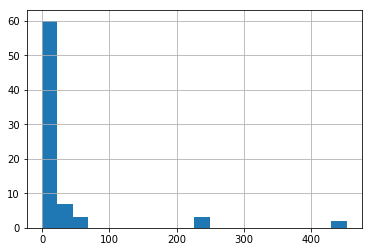

In [13]:
# Missing data across features
all_df.isna().sum().hist(bins=20)

### Missingness across wells

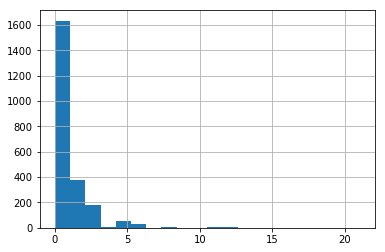

In [14]:
# Some wells have disproportionate amount of missing data
all_df.isna().sum(axis='columns').hist(bins=20)

## Output Mapping Dictionary

Note that this mapping was output and then manually edited by Gregory Way and Maria Alimova. The updated file is named `data/labels/feature_mapping_annotated.csv`.

In [15]:
file = os.path.join("data", "labels", "feature_mapping.tsv")

feature_df = (
    pd.DataFrame(
        {**viability_col_names,
         **cell_cycle_col_names},
        index=[0])
    .transpose()
    .reset_index()
    .rename({"index": "original_name",
             0: "updated_name"},
            axis='columns')
    .assign(
        feature_type = ["metadata"] * 4 + \
            ['cell_cycle'] + \
            ["viability"] * (len(viability_col_names) - 4) + \
            ['cell_cycle'] * (len(cell_cycle_col_names) - 6)
    )
)

feature_df.to_csv(file, sep='\t', index=False)
feature_df.head(2)

,original_name,updated_name,feature_type
0,Row,well_row,metadata
1,Column,well_col,metadata


## Count the Number of Guides for Each Measurement

In [16]:
guide_count_df = (
    all_df
    .groupby(
        ['cell_id', 'guide']
    )['plate_name']
    .count()
    .reset_index()
    .rename({'plate_name': 'num_guides'}, axis='columns')
    .sort_values(by=['num_guides', 'guide'])
    .reset_index(drop=True)
)

file = os.path.join("data", "labels", "num_guides_cell_health.tsv")
guide_count_df.to_csv(file, sep='\t', index=False)

guide_count_df.head(2)

,cell_id,guide,num_guides
0,A549,AKT1-1,4
1,ES2,AKT1-1,4
